In [29]:
import numpy as np
import tensorflow as tf

tf.reset_default_graph()
sess = tf.InteractiveSession()

ImportError: cannot import name 'helpers'

In [2]:
tf.__version__

'1.0.1'

In [3]:
PAD = 0
EOS = 1

vocab_size = 10
embedding_size = 20 


encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units*2

In [4]:
encoder_inputs = tf.placeholder(shape=(None,None), dtype = tf.int32, name = 'encoder_inputs')

In [5]:
encoder_inputs_length = tf.placeholder(shape=(None), dtype = tf.int32, name='encoder_inputs_length')

In [6]:
decoder_targets = tf.placeholder(shape=(None, None), dtype = tf.int32, name = 'decoder_inputs')

In [7]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0,1), dtype = tf.float32)
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

In [8]:
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple

In [9]:
encoder_cell = LSTMCell(encoder_hidden_units)

In [10]:
((encoder_fw_outputs,
  encoder_bw_outputs),
 (encoder_fw_final_state,
  encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                    cell_bw=encoder_cell,
                                    inputs=encoder_inputs_embedded,
                                    sequence_length=encoder_inputs_length,
                                    dtype=tf.float32, time_major=True)
    )

In [11]:
encoder_final_state_c =  tf.concat((encoder_fw_final_state.c, encoder_bw_final_state.c),1)
encoder_final_state_h = tf.concat((encoder_fw_final_state.h, encoder_bw_final_state.h),1)

encoder_final_state = LSTMStateTuple(c=encoder_final_state_c, h=encoder_final_state_h)

In [12]:
decoder_cell = LSTMCell(decoder_hidden_units)
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))
decoder_lengths = encoder_inputs_length + 3


In [13]:
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

In [14]:
assert EOS == 1 and PAD == 0

eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

In [15]:
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # all False at the initial step
    initial_input = eos_step_embedded
    initial_cell_state = encoder_final_state
    initial_cell_output = None
    initial_loop_state = None  # we don't need to pass any additional information
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

In [16]:
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):

    def get_next_input():
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        prediction = tf.argmax(output_logits, axis=1)
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    elements_finished = (time >= decoder_lengths) # this operation produces boolean tensor of [batch_size]
                                                  # defining if corresponding sequence has ended

    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, 
            input,
            state,
            output,
            loop_state)

In [17]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [18]:
decoder_outputs

<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 40) dtype=float32>

In [19]:
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

In [20]:
decoder_prediction = tf.argmax(decoder_logits, 2)

In [21]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [22]:

sess.run(tf.global_variables_initializer())

In [35]:
batch_size = 100
import helpers
batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[3, 9, 8, 8, 8, 3, 4, 4]
[8, 6, 4, 5, 5]
[9, 2, 5, 2, 2, 9, 3, 3]
[4, 6, 2, 6, 8, 7, 8]
[5, 9, 8, 5]
[5, 4, 2, 8]
[8, 4, 9, 4]
[5, 7, 8, 9, 6]
[7, 2, 7]
[8, 7, 3, 8]


In [36]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [37]:
loss_track = []

In [38]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.2689225673675537
  sample 1:
    input     > [7 9 9 8 8 3 2 9]
    predicted > [9 9 9 9 4 4 4 4 4 4 3]
  sample 2:
    input     > [2 3 4 2 9 3 7 0]
    predicted > [6 6 6 5 6 6 6 5 6 6 0]
  sample 3:
    input     > [6 8 7 8 3 8 6 0]
    predicted > [0 0 0 0 0 0 0 0 0 0 0]

batch 1000
  minibatch loss: 0.44547802209854126
  sample 1:
    input     > [9 9 4 0 0 0 0 0]
    predicted > [9 9 4 1 0 0 0 0 0 0 0]
  sample 2:
    input     > [7 3 8 9 5 2 3 0]
    predicted > [7 3 8 9 5 2 3 1 0 0 0]
  sample 3:
    input     > [7 3 9 0 0 0 0 0]
    predicted > [7 3 9 1 0 0 0 0 0 0 0]

batch 2000
  minibatch loss: 0.16256575286388397
  sample 1:
    input     > [2 9 4 9 7 5 0 0]
    predicted > [2 9 9 4 7 5 1 0 0 0 0]
  sample 2:
    input     > [8 6 4 7 0 0 0 0]
    predicted > [8 6 4 7 1 0 0 0 0 0 0]
  sample 3:
    input     > [2 2 5 0 0 0 0 0]
    predicted > [2 2 5 1 0 0 0 0 0 0 0]

batch 3000
  minibatch loss: 0.09461095929145813
  sample 1:
    input     > [9 

loss 0.0953 after 300100 examples (batch_size=100)


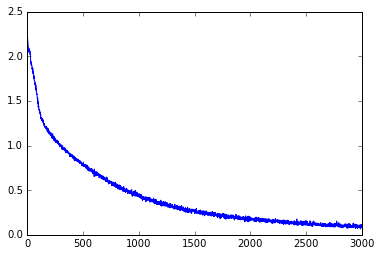

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))